# Zadanie 6


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [1]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np

In [2]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through layer"""
        raise NotImplementedError

    @abstractmethod
    def backward(self, output_error_derivative) -> np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        raise NotImplementedError

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert (
            learning_rate < 1
        ), f"Given learning_rate={learning_rate} is larger than 1"
        assert (
            learning_rate > 0
        ), f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate


class FullyConnected(Layer):
    def __init__(self, input_size: int, output_size: int, random_seed: int = 0) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        np.random.seed(random_seed)
        self.weights = np.random.uniform(
            low=-1 / np.sqrt(input_size),
            high=1 / np.sqrt(input_size),
            size=(input_size, output_size),
        )
        self.biases = np.random.randn(1, output_size)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.X = x
        self.Y = self.X @ self.weights + self.biases
        return self.Y

    def backward(self, output_error_derivative) -> np.ndarray:
        input_error = output_error_derivative @ self.weights.T
        weights_error = self.X.T @ output_error_derivative

        self.weights -= self.learning_rate * weights_error
        self.biases -= self.learning_rate * output_error_derivative
        return input_error


class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.X = x
        self.Y = np.tanh(x)
        return self.Y

    def backward(self, output_error_derivative) -> np.ndarray:
        return (1 - np.tanh(self.X) ** 2) * output_error_derivative


class Loss:
    def __init__(
        self, loss_function: callable, loss_function_derivative: callable
    ) -> None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function for a particular x"""
        return self.loss_function(x, y)

    def loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)


class Network:
    def __init__(self, layers: List[Layer], learning_rate: float = 0.01) -> None:
        self.layers = layers
        self.learning_rate = learning_rate
        if learning_rate != 0.01:
            for layer in self.layers:
                layer.learning_rate = learning_rate

    def compile(self, loss: Loss) -> None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def fit(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        epochs: int,
        learning_rate: float = 0.01,
        verbose: int = 0,
    ) -> None:
        """Fit the network to the training data"""
        number_of_samples = len(x_train)
        if learning_rate != self.learning_rate:
            for layer in self.layers:
                layer.learning_rate = learning_rate
        for i in range(epochs):
            error = 0
            for j in range(number_of_samples):
                output = self(x_train[j])
                error += np.mean(self.loss.loss(output, y_train[j]))
                error_derivative = self.loss.loss_derivative(output, y_train[j])
                for layer in reversed(self.layers):
                    error_derivative = layer.backward(error_derivative)
            if verbose > 0 and (i + 1) % verbose == 0:
                error /= number_of_samples
                print(f"episode number: {i+1} error on training set: {error:.4f}")

# XOR

In [3]:
x = np.array([[[0, 0]], [[0, 1]], [[1, 0]], [[1, 1]]])
y = np.array([[[0]], [[1]], [[1]], [[0]]])
network = Network(
    [FullyConnected(2, 5), Tanh(), FullyConnected(5, 3), Tanh(), FullyConnected(3, 1)]
)
loss = Loss(lambda x, y: np.power(y - x, 2), lambda x, y: 2 * (x - y) / y.size)
network.compile(loss)
network.fit(x, y, 500, verbose=100, learning_rate=0.1)

episode number: 100 error on training set: 0.3675
episode number: 200 error on training set: 0.0003
episode number: 300 error on training set: 0.0000
episode number: 400 error on training set: 0.0000
episode number: 500 error on training set: 0.0000


# Eksperymenty

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
def init_layers(dimensions_list, random_seed=0):
    layers = []
    for dimensions in dimensions_list:
        layers.append(FullyConnected(dimensions[0], dimensions[1], random_seed))
        layers.append(Tanh())
    return layers

In [6]:
def init_network(dimensions_list, random_seed=0):
    layers = init_layers(dimensions_list, random_seed)
    network = Network(layers)
    loss = Loss(lambda x, y: np.power(y - x, 2), lambda x, y: 2 * (x - y) / y.size)
    network.compile(loss)
    return network

In [7]:
def run_episodes(
    network,
    number_of_epochs,
    learning=0.01,
    test_ratio=0.1,
    random_seed=0,
    verbose=0,
):
    network = network
    msint = load_digits()
    x = np.array(msint.data)
    y = np.array(msint.target)

    y_temp = np.zeros((len(y), 10))
    for array, value in zip(y_temp, y):
        array[value] = 1
    y = y_temp

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_ratio, random_state=random_seed
    )
    
    network.fit(
        np.array(x_train).reshape((-1, 1, 64)),
        y_train,
        epochs=number_of_epochs,
        learning_rate=learning,
        verbose=verbose,
    )

    error = 0
    error_with_rounding = 0
    for x, y in zip(x_test, y_test):
        out = network(x)
        rounded = np.round(out)
        error += (y - out) ** 2
        error_with_rounding += (y - rounded) ** 2
    return (sum(error[0]) / len(y_test), sum(error_with_rounding[0]) / len(y_test))

In [8]:
network = init_network([(64, 80), (80, 60), (60, 30), (30, 10)])
error, error_with_rounding = run_episodes(
    network, 100, learning=0.01, verbose=10
)
print(
    f"Error of test set: {error:.4f}\nError of test set with rounding final output vector: {error_with_rounding:.4f}"
)

episode number: 10 error on training set: 0.0164
episode number: 20 error on training set: 0.0086
episode number: 30 error on training set: 0.0059
episode number: 40 error on training set: 0.0045
episode number: 50 error on training set: 0.0036
episode number: 60 error on training set: 0.0029
episode number: 70 error on training set: 0.0025
episode number: 80 error on training set: 0.0021
episode number: 90 error on training set: 0.0018
episode number: 100 error on training set: 0.0016
Error of test set: 0.0616
Error of test set with rounding final output vector: 0.0556


In [9]:
network = init_network([(64, 80), (80, 60), (60, 30), (30, 10)])
for _ in range(10):
    run_episodes(network, 10, verbose=10)

episode number: 10 error on training set: 0.0164
episode number: 10 error on training set: 0.0086
episode number: 10 error on training set: 0.0059
episode number: 10 error on training set: 0.0045
episode number: 10 error on training set: 0.0036
episode number: 10 error on training set: 0.0029
episode number: 10 error on training set: 0.0025
episode number: 10 error on training set: 0.0021
episode number: 10 error on training set: 0.0018
episode number: 10 error on training set: 0.0016


In [18]:
network = init_network([(64, 40), (40, 20), (20, 10)])
for _ in range(10):
    run_episodes(network, 10, verbose=10)

episode number: 10 error on training set: 0.0184
episode number: 10 error on training set: 0.0103
episode number: 10 error on training set: 0.0074
episode number: 10 error on training set: 0.0059
episode number: 10 error on training set: 0.0049
episode number: 10 error on training set: 0.0042
episode number: 10 error on training set: 0.0037
episode number: 10 error on training set: 0.0033
episode number: 10 error on training set: 0.0030
episode number: 10 error on training set: 0.0027


In [19]:
network = init_network([(64, 10), (10, 10)])
for _ in range(10):
    run_episodes(network, 10, verbose=10)

episode number: 10 error on training set: 0.0543
episode number: 10 error on training set: 0.0380
episode number: 10 error on training set: 0.0362
episode number: 10 error on training set: 0.0349
episode number: 10 error on training set: 0.0263
episode number: 10 error on training set: 0.0253
episode number: 10 error on training set: 0.0250
episode number: 10 error on training set: 0.0248
episode number: 10 error on training set: 0.0246
episode number: 10 error on training set: 0.0245


In [10]:
def create_scatter_plots(dimensions_list, random_seed, learning_rate=0.01):
    network = init_network(dimensions_list, random_seed)
    number_of_episodes = range(10, 110, 10)
    error_rates = np.zeros(10)
    error_rates_with_rounding = np.zeros(10)
    for i in range(10):
        error_rates[i], error_rates_with_rounding[i] = run_episodes(network, 10, learning_rate, random_seed=random_seed)
    fig, ax = plt.subplots(nrows=1, ncols=2,  figsize=(13,6.15))
    fig.text(0.25, 0 ,f"Architecture: {dimensions_list}, random seed: {random_seed}, learning rate: {learning_rate}")
    ax[0].scatter(number_of_episodes, error_rates, color="green")
    ax[0].set_xlabel("Number of episodes")
    ax[0].set_ylabel("Error Rate")
    ax[0].set_xlim(0.0, 110)
    ax[0].set_ylim(0.0, 1.1)
    ax[0].set_title(f"Error rate of test set")
    ax[1].scatter(number_of_episodes, error_rates_with_rounding)
    ax[1].set_xlabel(f"Error Rate with rounding")
    ax[1].set_ylabel("Error Rate")
    ax[1].set_xlim(0, 110)
    ax[1].set_ylim(0, 1.1)
    ax[1].set_title(f"Error rate with rounfing of test set")
    plt.show()
        

# Wnioski

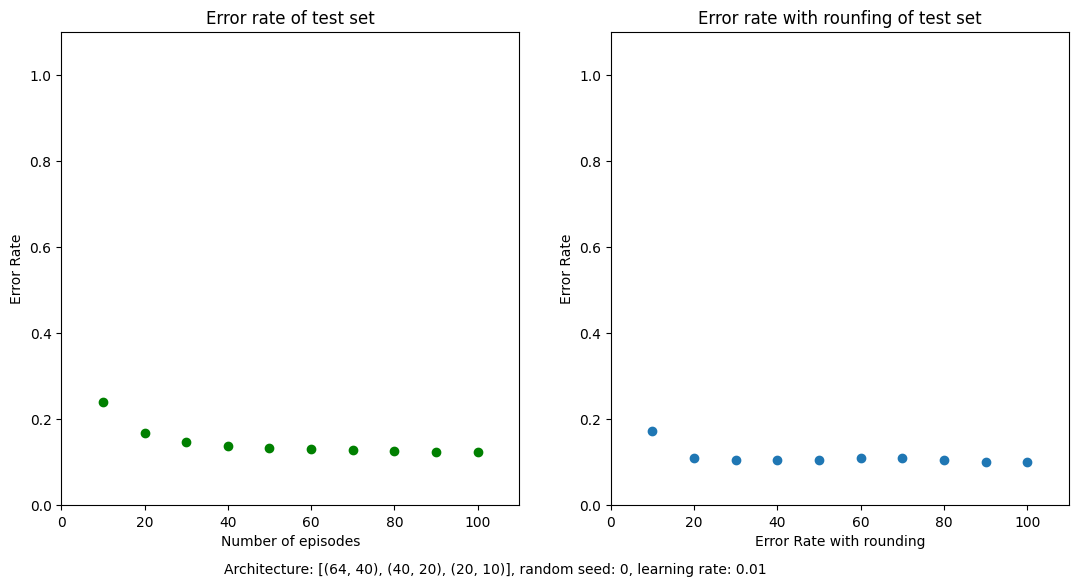

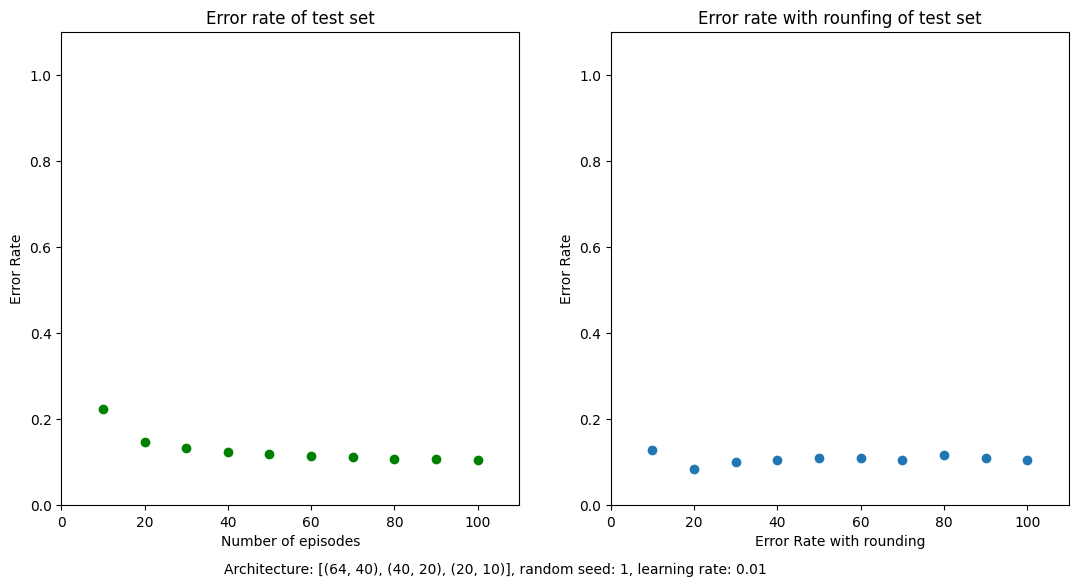

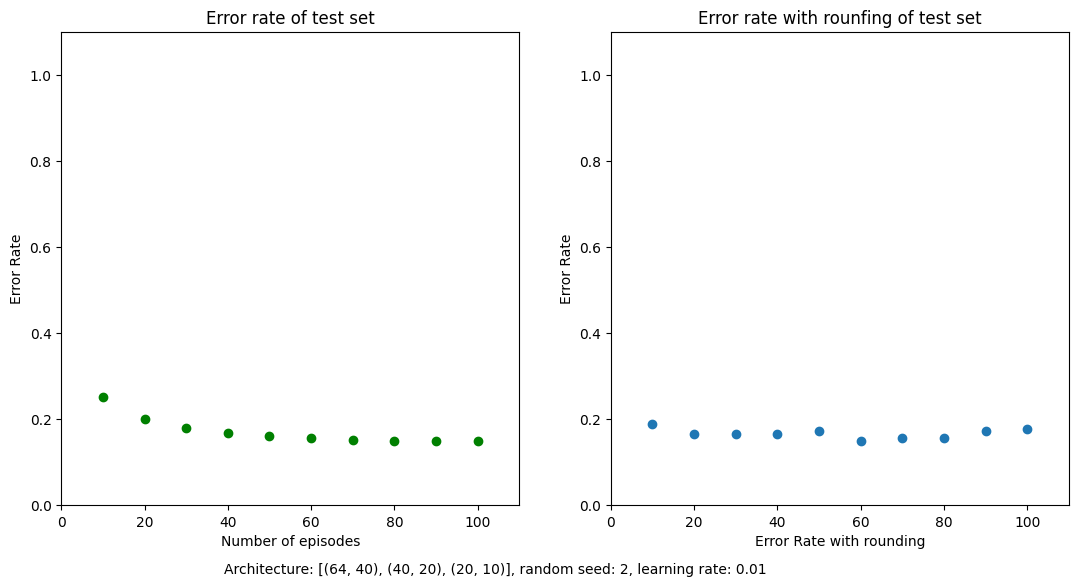

In [11]:
create_scatter_plots([(64, 40), (40, 20), (20, 10)], random_seed=0, learning_rate=0.01)
create_scatter_plots([(64, 40), (40, 20), (20, 10)], random_seed=1, learning_rate=0.01)
create_scatter_plots([(64, 40), (40, 20), (20, 10)], random_seed=2, learning_rate=0.01)

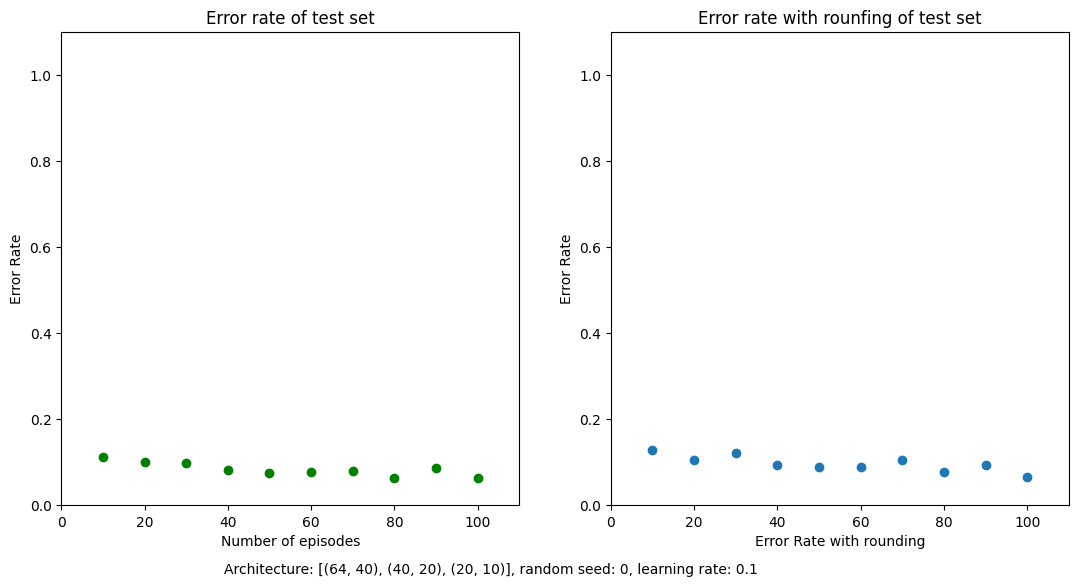

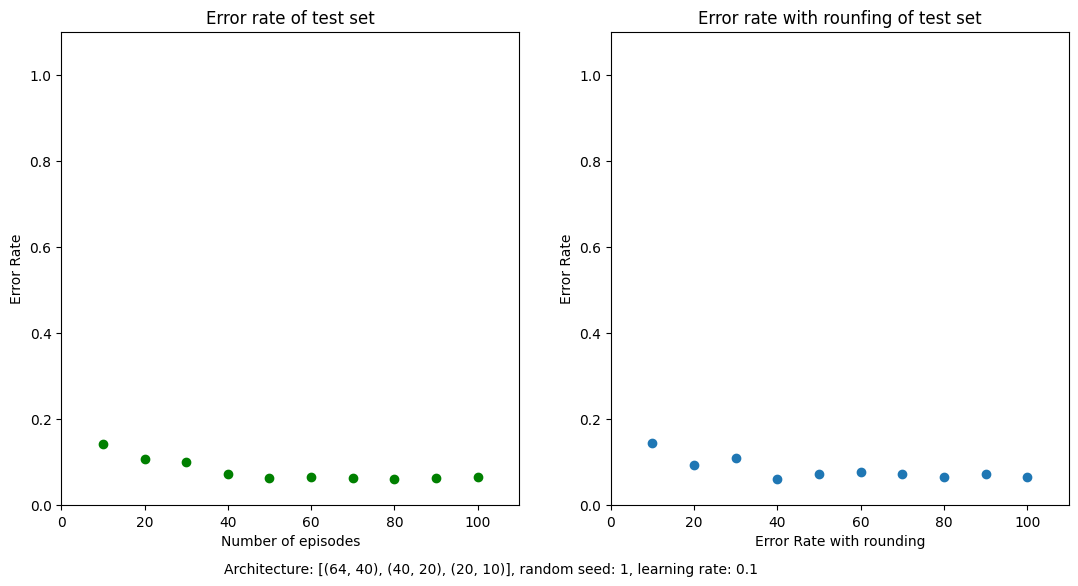

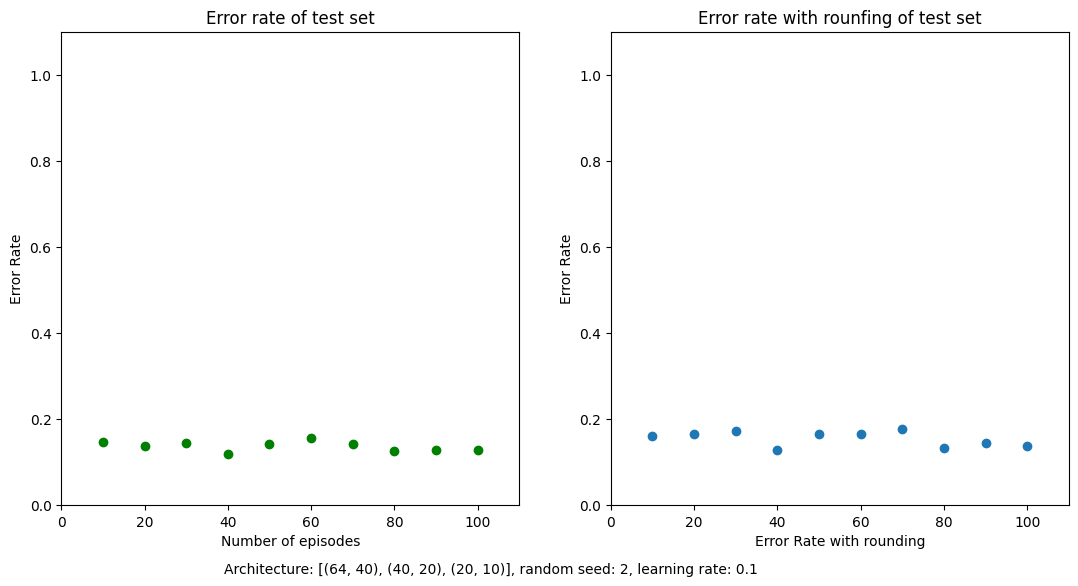

In [12]:
create_scatter_plots([(64, 40), (40, 20), (20, 10)], random_seed=0, learning_rate=0.1)
create_scatter_plots([(64, 40), (40, 20), (20, 10)], random_seed=1, learning_rate=0.1)
create_scatter_plots([(64, 40), (40, 20), (20, 10)], random_seed=2, learning_rate=0.1)

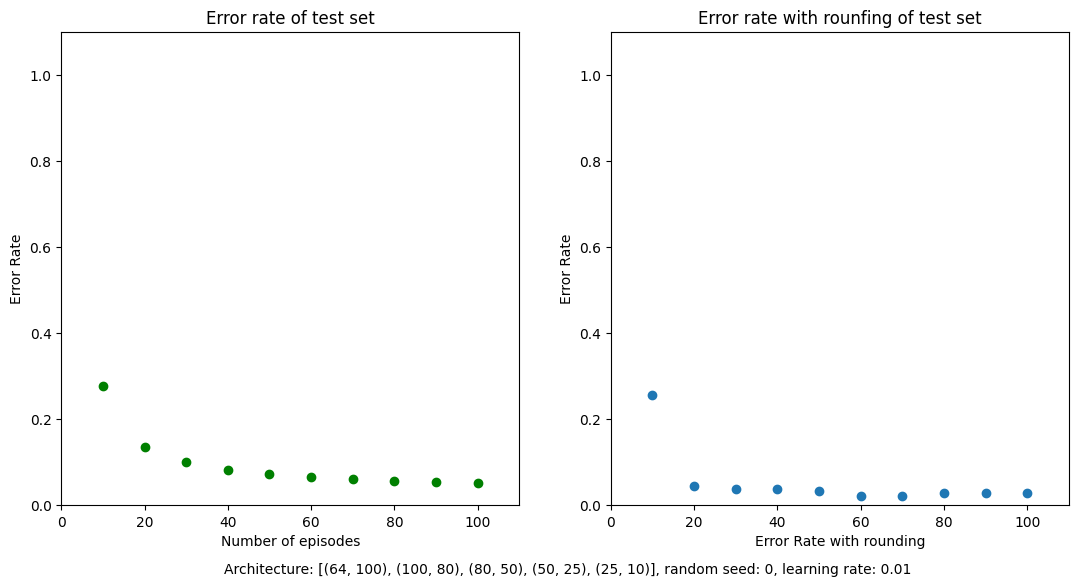

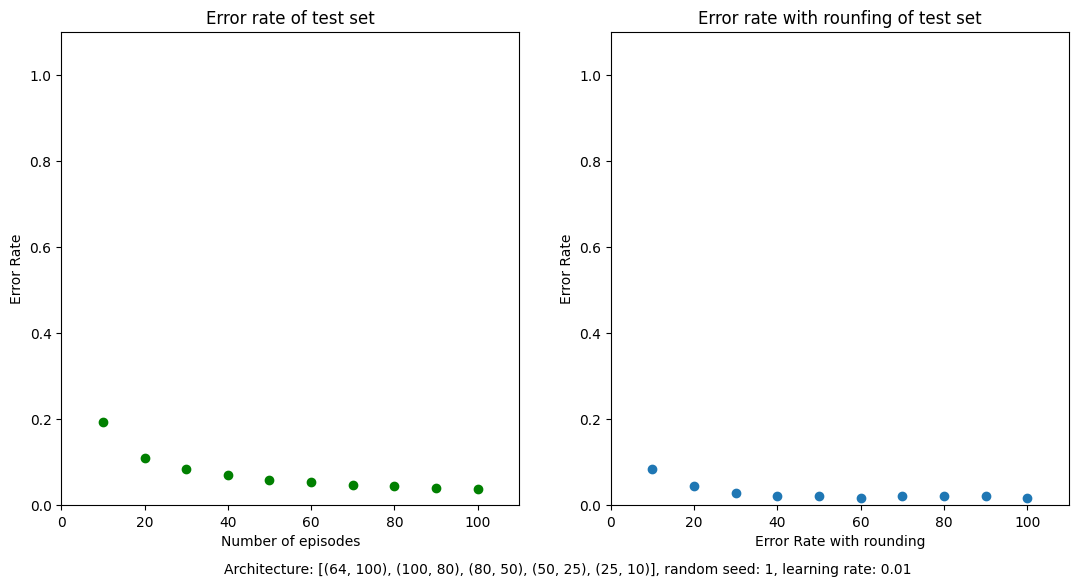

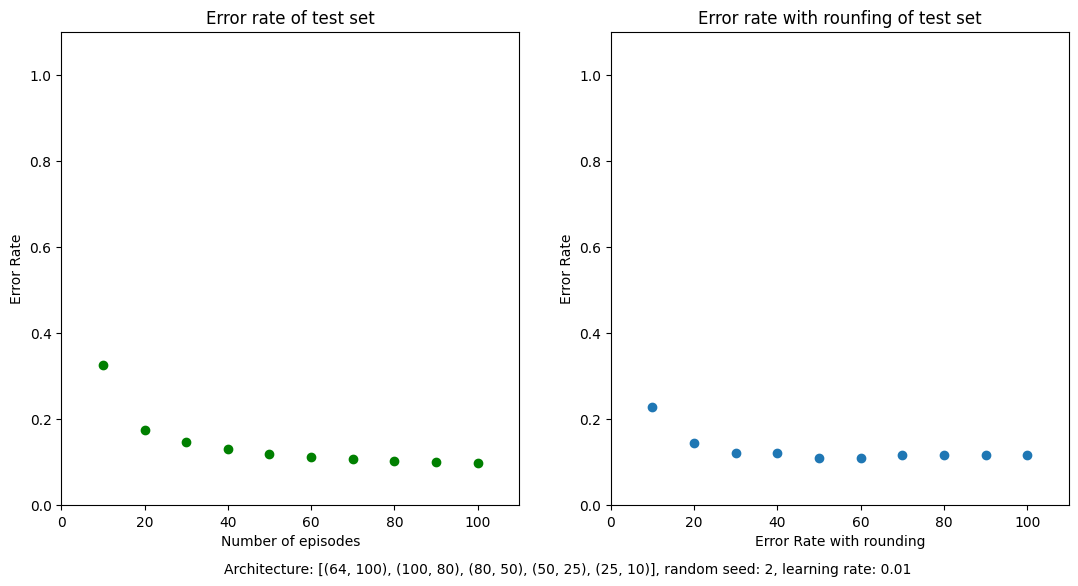

In [13]:
create_scatter_plots([(64, 100), (100, 80), (80, 50), (50, 25), (25, 10)], random_seed=0, learning_rate=0.01)
create_scatter_plots([(64, 100), (100, 80), (80, 50), (50, 25), (25, 10)], random_seed=1, learning_rate=0.01)
create_scatter_plots([(64, 100), (100, 80), (80, 50), (50, 25), (25, 10)], random_seed=2, learning_rate=0.01)

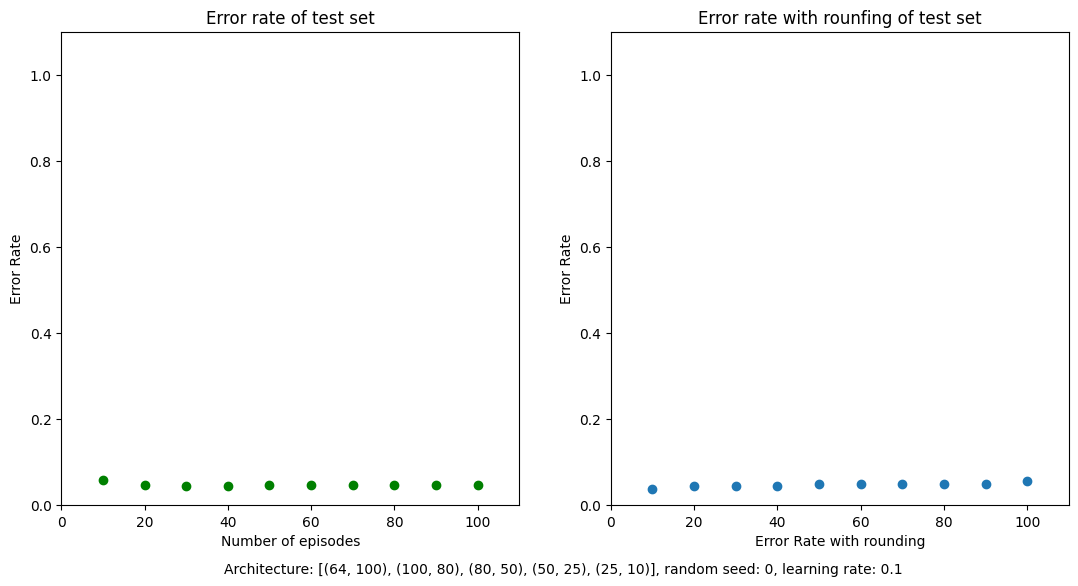

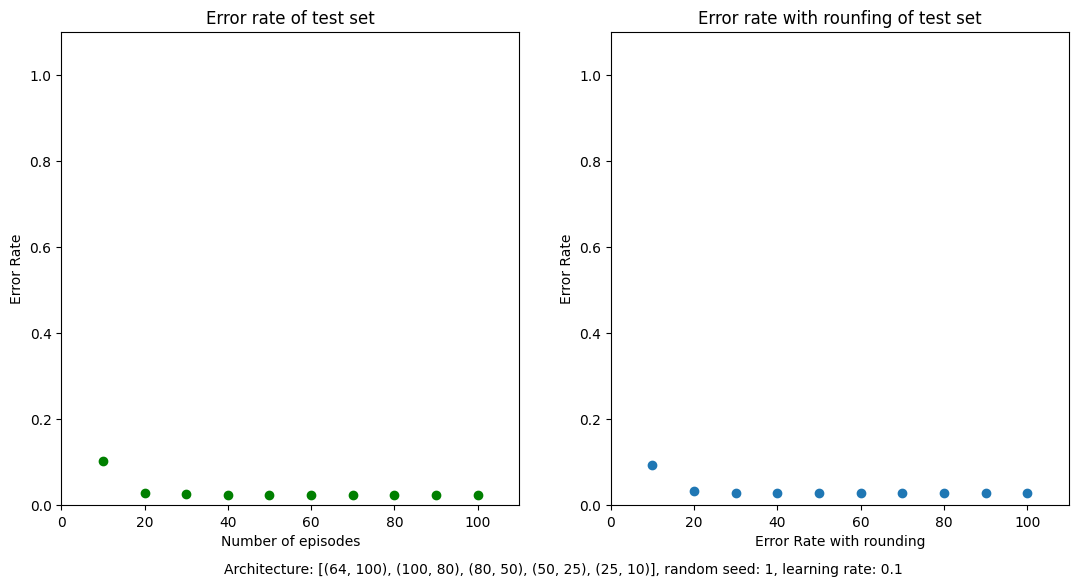

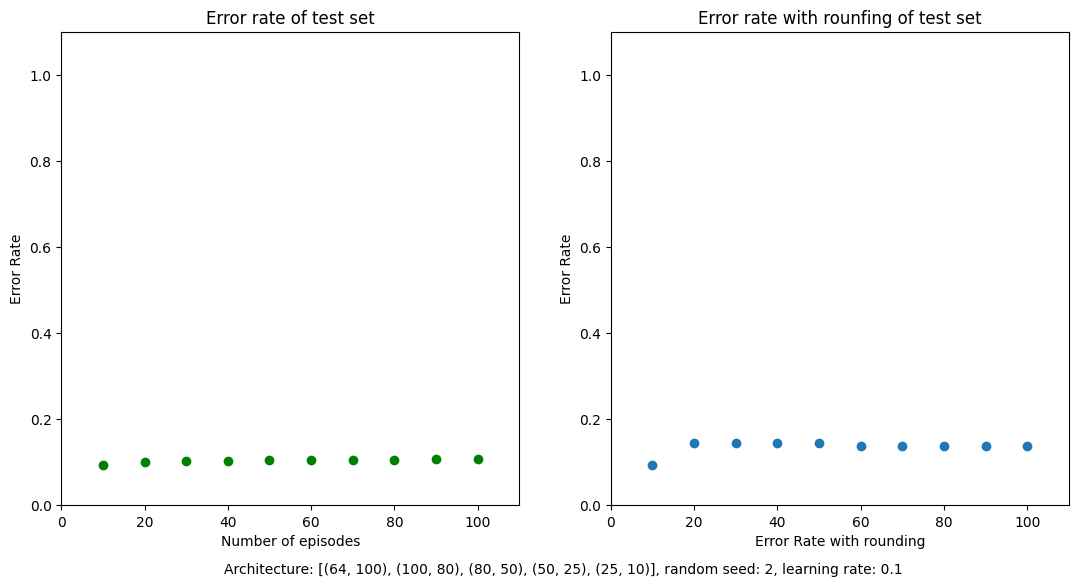

In [14]:
create_scatter_plots([(64, 100), (100, 80), (80, 50), (50, 25), (25, 10)], random_seed=0, learning_rate=0.1)
create_scatter_plots([(64, 100), (100, 80), (80, 50), (50, 25), (25, 10)], random_seed=1, learning_rate=0.1)
create_scatter_plots([(64, 100), (100, 80), (80, 50), (50, 25), (25, 10)], random_seed=2, learning_rate=0.1)

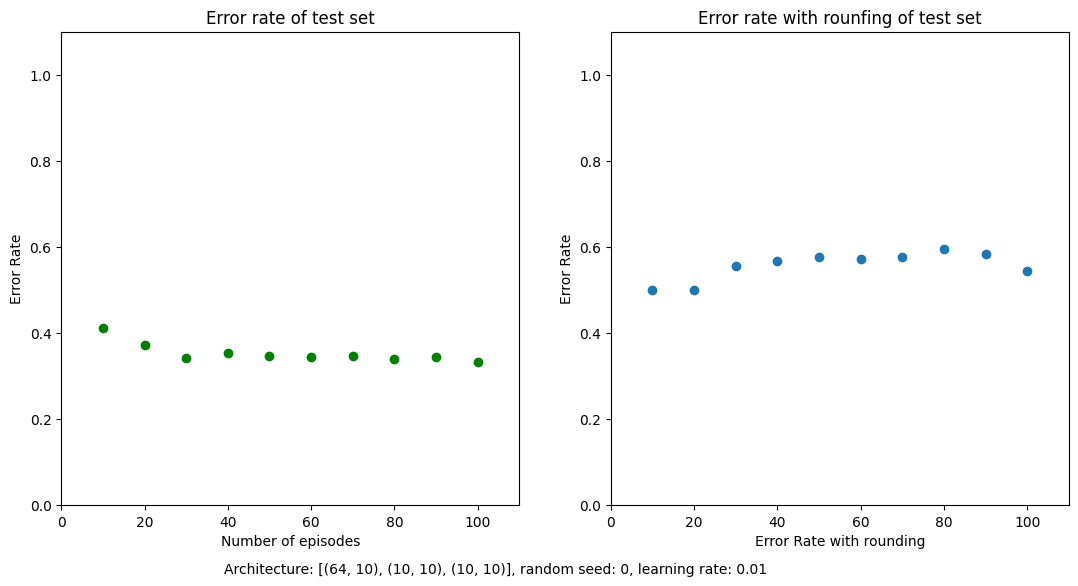

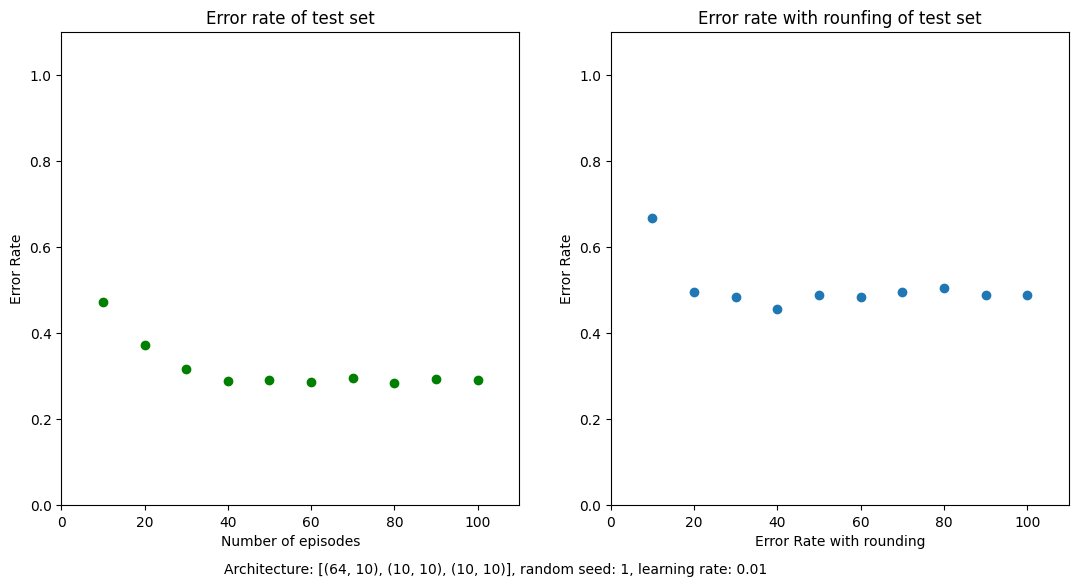

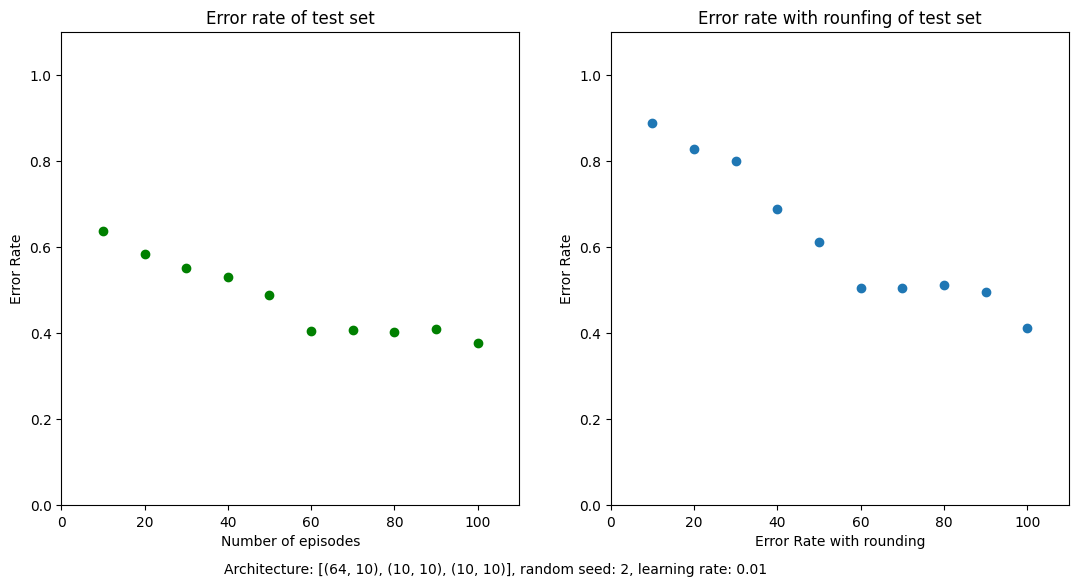

In [15]:
create_scatter_plots([(64, 10), (10, 10), (10, 10)], random_seed=0, learning_rate=0.01)
create_scatter_plots([(64, 10), (10, 10), (10, 10)], random_seed=1, learning_rate=0.01)
create_scatter_plots([(64, 10), (10, 10), (10, 10)], random_seed=2, learning_rate=0.01)

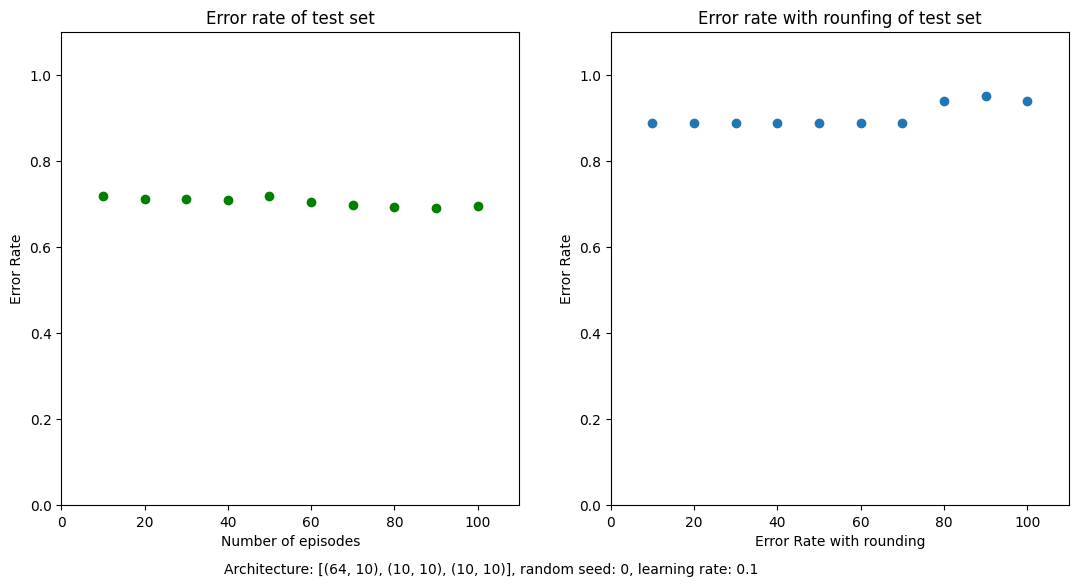

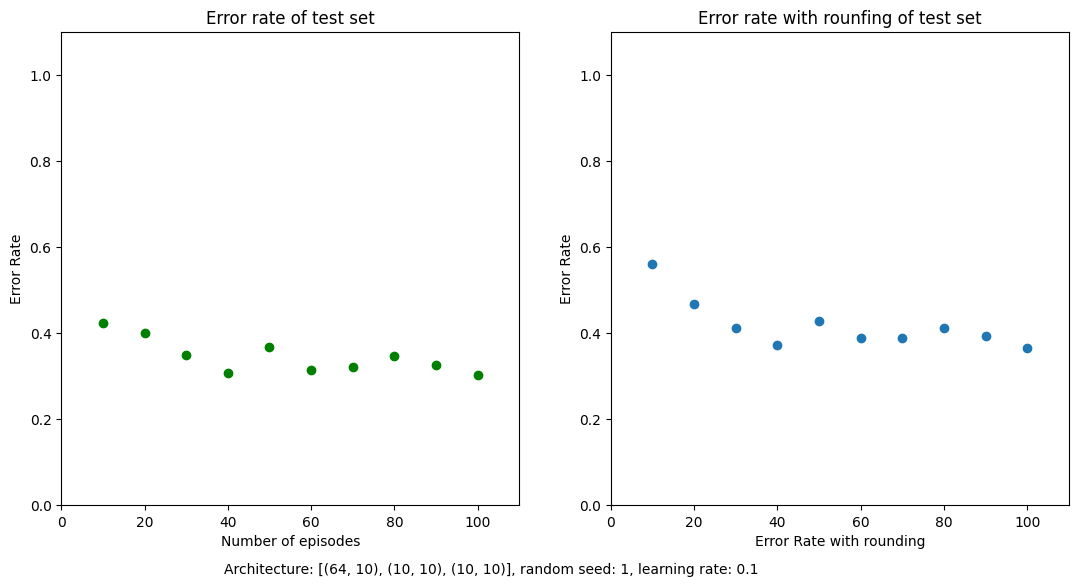

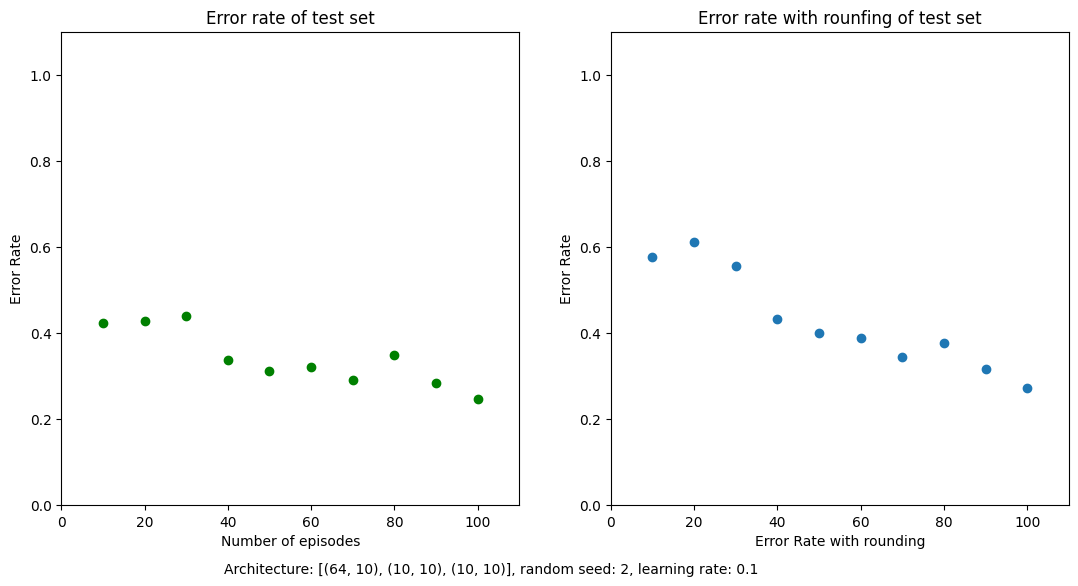

In [16]:
create_scatter_plots([(64, 10), (10, 10), (10, 10)], random_seed=0, learning_rate=0.1)
create_scatter_plots([(64, 10), (10, 10), (10, 10)], random_seed=1, learning_rate=0.1)
create_scatter_plots([(64, 10), (10, 10), (10, 10)], random_seed=2, learning_rate=0.1)

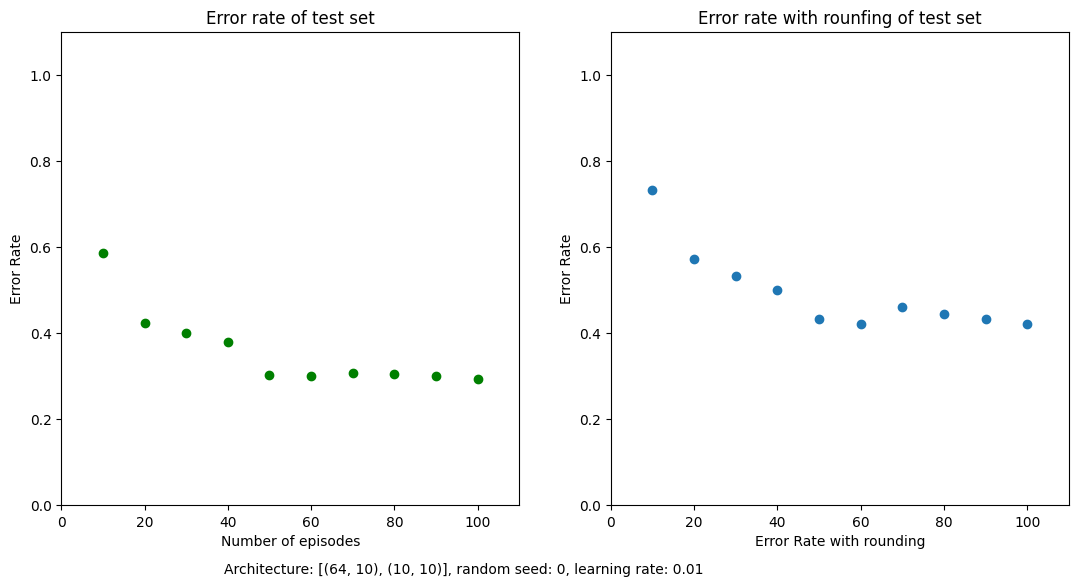

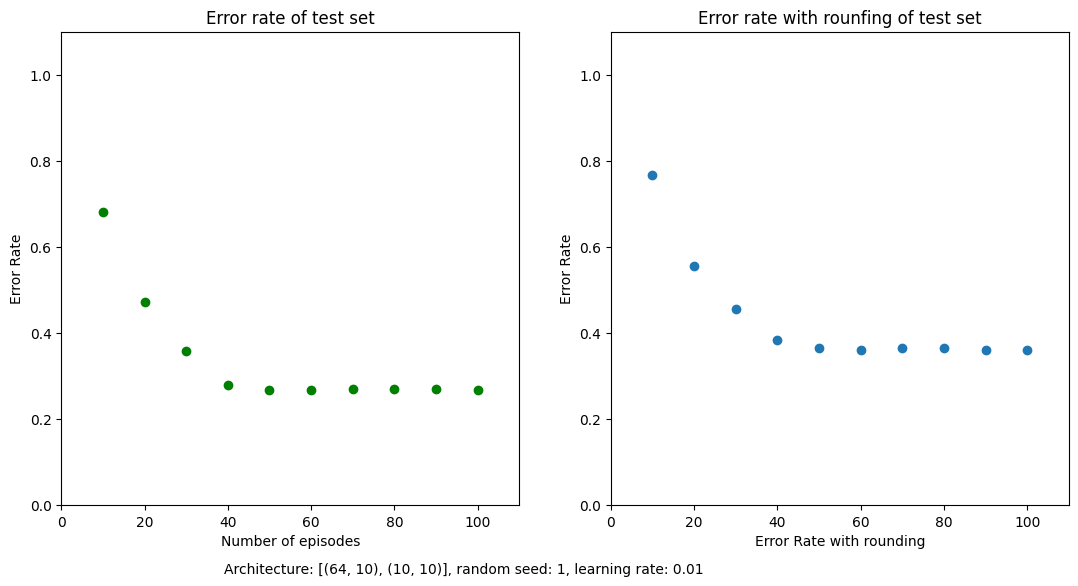

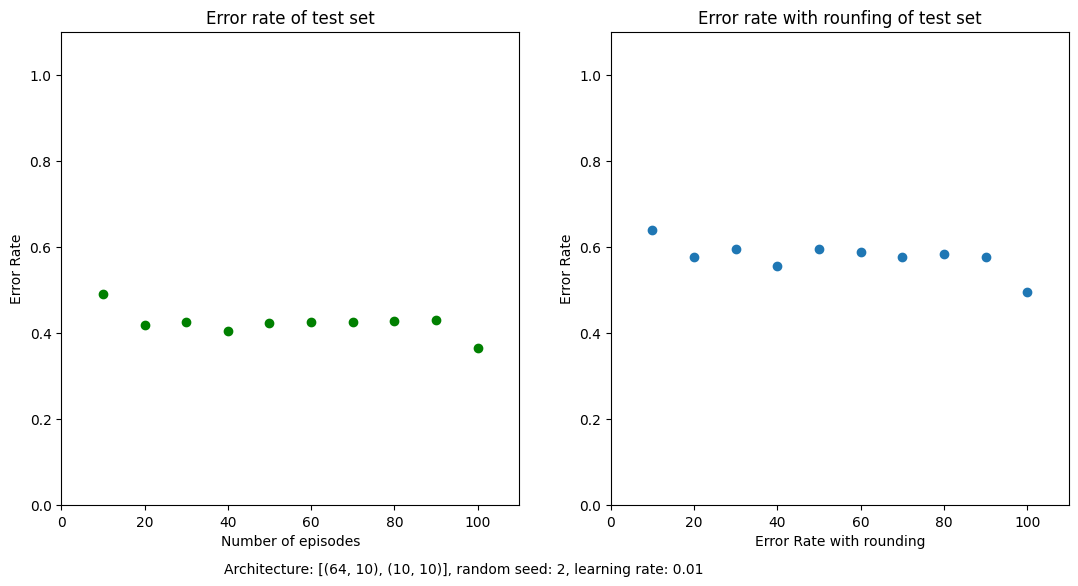

In [17]:
create_scatter_plots([(64, 10), (10, 10)], random_seed=0, learning_rate=0.01)
create_scatter_plots([(64, 10), (10, 10)], random_seed=1, learning_rate=0.01)
create_scatter_plots([(64, 10), (10, 10)], random_seed=2, learning_rate=0.01)

# Wnioski

Sieci neuronowe z rozbudowaną architekturą mają większe mozliwości na dostosowanie swoch parametrów do określonego zadania, dlatego osiągają lepsze rezultaty od sieci prostych.

Skuteczność wytrenowanego modelu jest w uzależniona od reprezentatywności zbioru trenującego. Powyższe wykresy pokazują, że dla różnych zbiorów trenujących, jedna architektura może osiągać bardzo zróżnicowane wyniki, zatem zbiór trenujący musi być odpowiednio duży oraz być wybrany z pełnej populacji z odpowiednim rozkładem losowym.

Na maksymalną skuteczność, wpływ mają również początkowe wartości wag oraz obciążęń. Jeśli początkowa wartość funkcji kosztu (straty) znajduje się blisko optimum lokalnego, model może nie osiągnąć maksymalnej skuteczności, dlatego warto trenować model wiele razy, z różnymi parametrami startowymi.

Parametr learning rate odpowiada za wielkość aktualizacji wag i obciążeń. Większy rozmiar może prowadzić do szybszej nauki, a także daje lepsze szanse na opuszczenie minima lokalnego, jednak wprowadza ryzyko, że model nigdy nie osiagnie dobrej skuteczności.


